In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math
from bisect import bisect

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 7.0]
mpl.rcParams['figure.dpi'] = 100

In [3]:
# hyperparameters

seed = random.randint(1, 1000)                              # random seed

# Step 1
## Graph generation, train/test splitting and feature generation

Generate/import graph from avalible `generator` classes

In [4]:
from lib.generators.LFR import LFR
from lib.generators.OLP import OLP


generator = LFR(n=5000, t1=3, t2=1.1, m=0.1, seed=seed)
feature_names = generator.feature_names

Generating LFR graph...
Graph generated!
Train/test splitting...
Done splitting the data!
Calculating ['RAI', 'JC', 'AAI', 'PA'] features...
Done calculating


In [5]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [6]:
link_prediction_train['goal'].value_counts()

0.0    3302
1.0    3302
Name: goal, dtype: int64

In [7]:
link_prediction_test['goal'].value_counts()

0.0    1873946
1.0        679
Name: goal, dtype: int64

In [8]:
classifier_test['goal'].value_counts()

0.0    1873936
1.0        689
Name: goal, dtype: int64

# Step 3
## Link prediction model

Predict links using one of the avalble link prediction models

In [9]:
from lib.link_prediction_models.RandomForestOnFeatures import RandomForestOnFeatures

model = RandomForestOnFeatures(X_train=link_prediction_train[feature_names], Y_train=link_prediction_train['goal'], random_state=seed)

prob = model.predict_proba(link_prediction_test[feature_names])
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prob
0,55,4057,0.0,0.0,0.0,0.0,0.010714,0.530195
1,2806,3643,0.0,0.0,0.0,0.0,0.010714,0.000000
2,2717,4246,0.0,0.0,0.0,0.0,0.035714,0.206886
3,3155,3359,0.0,0.0,0.0,0.0,0.017857,0.206886
4,674,3070,0.0,0.0,0.0,0.0,0.003571,0.206886


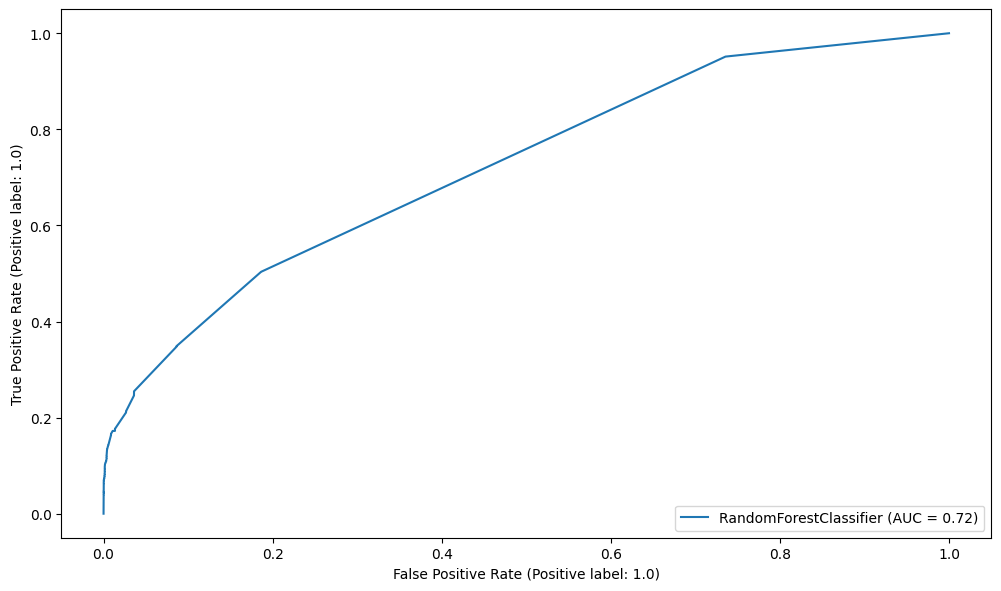

In [10]:
from sklearn import metrics


metrics.plot_roc_curve(model.get_model(), link_prediction_test[feature_names], link_prediction_test['goal'])  

# Step 4
## Quality class analisys

In [11]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error
0,55,4057,0.0,0.0,0.0,0.0,0.010714,0.530195,0.530195
1,2806,3643,0.0,0.0,0.0,0.0,0.010714,0.000000,0.000000
2,2717,4246,0.0,0.0,0.0,0.0,0.035714,0.206886,0.206886
3,3155,3359,0.0,0.0,0.0,0.0,0.017857,0.206886,0.206886
4,674,3070,0.0,0.0,0.0,0.0,0.003571,0.206886,0.206886


In [12]:
# statistics on error
link_proba['abs_error'].describe()

count    6604.000000
mean        0.503178
std         0.341086
min         0.000000
25%         0.206886
50%         0.503164
75%         0.793114
max         1.000000
Name: abs_error, dtype: float64

In [13]:
median_error = link_proba['abs_error'].median()
median_error

0.5031637774896054

In [14]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] >= median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,RAI,JC,AAI,PA,prob,abs_error,quality_label
0,55,4057,0.0,0.0,0.0,0.0,0.010714,0.530195,0.530195,1
1,2806,3643,0.0,0.0,0.0,0.0,0.010714,0.000000,0.000000,0
2,2717,4246,0.0,0.0,0.0,0.0,0.035714,0.206886,0.206886,0
3,3155,3359,0.0,0.0,0.0,0.0,0.017857,0.206886,0.206886,0
4,674,3070,0.0,0.0,0.0,0.0,0.003571,0.206886,0.206886,0


In [22]:
link_proba['quality_label'].value_counts()

1    3309
0    3295
Name: quality_label, dtype: int64

# Step 5
## Quality class prediction

In [15]:
# train for quality class prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

clf = LogisticRegression(random_state=seed)  #clf = LogisticRegression(random_state=seed, class_weight='balanced')
#clf = clf = DecisionTreeClassifier(random_state=seed)
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=seed)

clf.fit(link_proba[feature_names], link_proba['quality_label'])

LogisticRegression(random_state=261)

In [16]:
# testing the classifier

pred = clf.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] >= median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,RAI,JC,AAI,PA,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,6,1263,1.0,0.00,0.000000,0.000000,0.002820,0.206886,0,0.793114,1
1,6,4884,1.0,0.00,0.000000,0.000000,0.005639,0.372595,0,0.627405,1
2,12,218,1.0,0.25,0.142857,0.721348,0.011278,0.772512,1,0.227488,0
3,15,4807,1.0,0.00,0.000000,0.000000,0.001880,0.206886,0,0.793114,1
4,19,1133,1.0,0.00,0.000000,0.000000,0.003759,0.206886,0,0.793114,1


In [17]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
0                     1839125
1                       35500
dtype: int64

In [18]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
0                          1866662
1                             7963
dtype: int64

In [19]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    clf.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1.874625e+06
1,Accuracy,9.843633e-01
2,Precision,9.366283e-01
3,Recall,9.843633e-01
4,F1 score,9.794679e-01


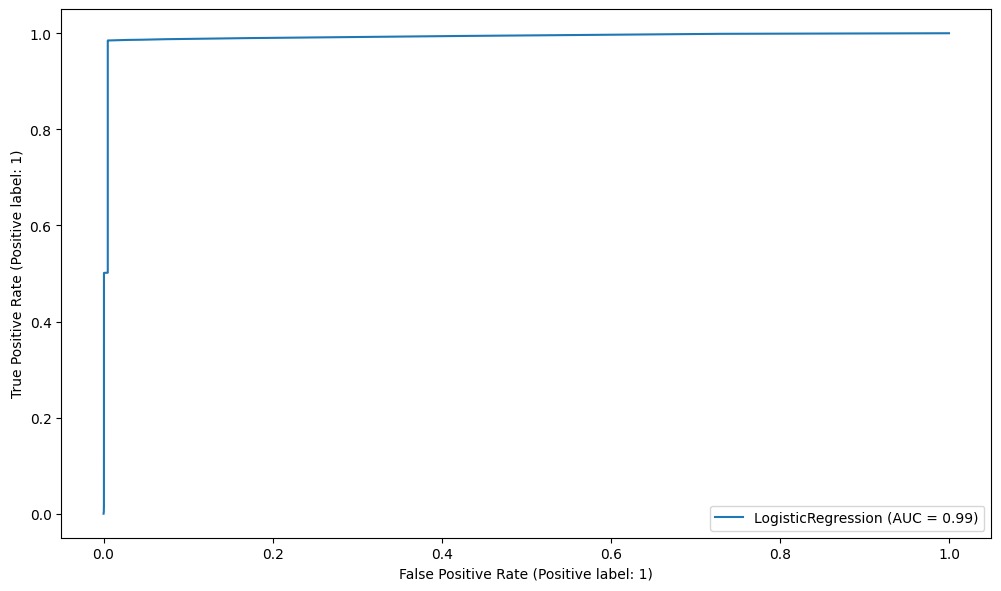

In [20]:
metrics.plot_roc_curve(clf, classifier_test[feature_names], classifier_test['true_quality_label'])  

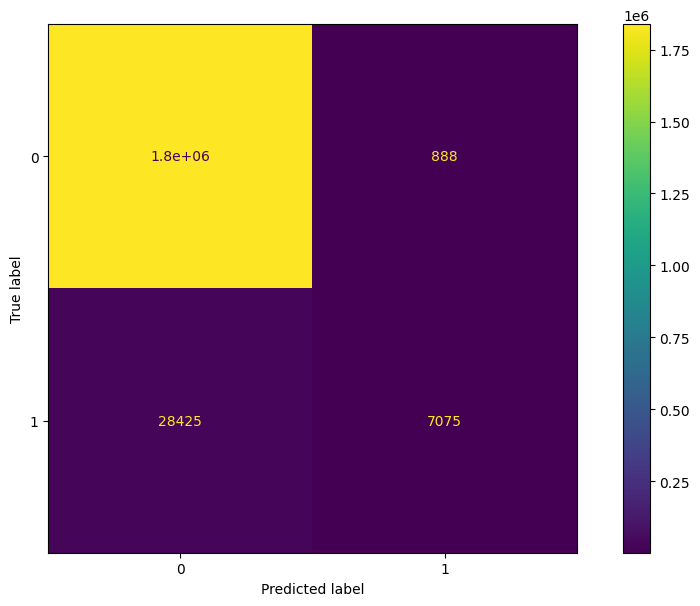

In [21]:
metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])